#  Do Asimov scan

- Create an Asimov dataset using importance sampling
- Importance sampling is performed either (a) around the SM EWK prediction, or (b) using a density model describing the importance measure at a pre-defined reference point


In [3]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt
import scipy

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, bin_data_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename
from backends import plot, density_model

print("Importing tensorflow and keras")
import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends
Importing tensorflow and keras


In [71]:
#  Inputs config

load_model_EWK        = ".EWK_density_model"
load_model_QCD        = ".QCD_density_model_2M"
xsection_models_fname = ".xsection_models.pickle"
load_whitening_funcs  = ".whitening_funcs.pickle"

L               = 140e3         # integrated luminosity in /pb
n_gen_EWK       = int(100000)   # number of events to importance sample
n_gen_QCD       = int(200000)   # number of events to importance sample
n_asimov        = int(1e6)

importance_sampling_cWtil = 0.10

In [24]:
#  Load functions for whitening/unwhitening the data
#

print(f"Loading whitening functions from file {load_whitening_funcs}")
whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))


Loading whitening functions from file .whitening_funcs.pickle


In [6]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order  = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]
observables_types  = [int if obs in int_observables else float for obs in observables_order]
observables_labels = {"m_jj":r"$m_{\rm jj}$", "m_ll":r"$m_{\rm ll}$", "Dphi_j_j":r"$\Delta\phi(j,j)$", "Dy_j_j":r"$\Delta y(j,j)$"}

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


---

### Load cross section and density models

- Load xsections from file created by get_EWK_and_QCD_cross_section_models
- Since $\Delta\sigma_{\rm QCD}$ is 10x bigger than the variation of  $\sigma_{\rm EWK}$ with $c$, we assume $\sigma_{\rm EWK}$ to be constant. This makes our lives easier later on.
- Also load density models

---

In [7]:
#  Load EWK and QCD cross sections
#

xsection_models = pickle.load(open(xsection_models_fname, "rb"))

sigma_QCD     = xsection_models ["QCD_cross_section"]
sigma_QCD_err = xsection_models ["QCD_cross_section_err"]
sigma_EWK     = xsection_models ["EWK_paramA"]
sigma_tot     = sigma_EWK + sigma_QCD

print(f"sigma_EWK = {sigma_EWK:.3f}")
print(f"sigma_QCD = {sigma_QCD:.3f} +/- {sigma_QCD_err:.3f}")
print(f"sigma_tot = {sigma_tot:.3f}")


sigma_EWK = 0.290
sigma_QCD = 13.828 +/- 0.013
sigma_tot = 14.118


In [8]:
#  Load EWK and QCD density models
#

density_model_EWK = DensityModel.from_dir(load_model_EWK)
for m in density_model_EWK.likelihood_models :
    m.model.summary()

density_model_QCD = DensityModel.from_dir(load_model_QCD)
for m in density_model_QCD.likelihood_models :
    m.model.summary()


INFO       DensityModel.construct      Set model name           : dflt
INFO       DensityModel.construct      Set model num_gaussians  : 2
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 1
INFO       DensityModel.construct      Set observable types     : [<class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer   : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer     : zeros
Model: "EWK_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 7)            

Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 7)            14          input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 7)            0           dense_45[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 40)           320         leaky_re_lu_27[0][0]             
______________________________________________________________________

---

### Make evaluator model for full likelihood

- Figure out number of Gaussians used for EWK and QCD models
- Define EWK + QCD likelihood model using a combined graph to push through tensorflow, as this is faster than doing everything in numpy
- EWK_logL_model and QCD_logL_model compute the EWK and QCD logLs for datapoints
- FullEvaluatorModel computes the logL by computing the EWK and QCD likelihoods and combining them
- EvaluatorModel computes the logL by computing the EWK likelihood and combining with a pre-computed QCD part (to avoid re-calculating this every time we update c)

---

In [9]:
#  Figure out how many Gaussians are used for each model
#  -  assumed that all layers have the same number
#

EWK_gauss_params_dummy = density_model_EWK.likelihood_models[0].get_gauss_params([0])
num_gauss_EWK          = int(EWK_gauss_params_dummy.shape[1] / 3)
print(f"EWK model with {num_gauss_EWK} Gaussians per layer")

QCD_gauss_params_dummy = density_model_QCD.likelihood_models[0].get_gauss_params([0])
num_gauss_QCD          = int(QCD_gauss_params_dummy.shape[1] / 3)
print(f"QCD model with {num_gauss_QCD} Gaussians per layer")


W1019 09:33:37.732660 4697716160 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


EWK model with 20 Gaussians per layer
QCD model with 20 Gaussians per layer


In [10]:
#  Create logL models using tf and keras for speed
#

sqrt_2pi = np.sqrt(2*np.pi)

#  Keras implementation of Gaussian PDF
#
def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)


#  Keras calculation of likelihood per-datapoint
#
def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob


#  Keras calculation of log-likelihood per-datapoint
#
def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))


#  Keras calculation of log-likelihood for set of datapoints
#
def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)


#  Keras calculation of EWK log-likelihood for set of datapoints
#
def K_get_log_likelihood_EWK (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, num_gauss_EWK)


#  Keras calculation of EWK log-likelihood for set of datapoints
#
def K_get_log_likelihood_QCD (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, num_gauss_QCD)


#  Keras layer to combine EWK and QCD logL values for set of datapoints
#
def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)


In [11]:
#  Get lists of Keras EWK and QCD density models
#
EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]


#  Define input layers for evaluator models
#
condition_input_layer_cWtil = Input((1,), name="cWtil_input")
condition_input_layer_QCD   = Input((1,), name="QCD_input")
obs_input_layer             = Input((num_observables,), name="observable_input")


#  Split inputs and pipe them through individual layers of the EWK and QCD density models
#  -  each one models a separate conditional probability, to be combined afterwards
#
EWK_logL_layers, QCD_logL_layers = [], []
for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        cond_obs_split_layer = Lambda(lambda x : x[:, :i], name=f"split_observable_below{i}")(obs_input_layer)
        model_inputs_EWK.append(cond_obs_split_layer)
        model_inputs_QCD.append(cond_obs_split_layer)
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i], name=f"split_observable_eq{i}")(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood_EWK, name=f"EWK_logL_observable{i}")([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood_QCD, name=f"QCD_logL_observable{i}")([eval_p, QCD_params]))

#  Keras Lambda layers to perform conditional probability combination
#
EWK_logL = Lambda(lambda x : tf.add_n(x), name="EWK_logL_total")(EWK_logL_layers)
QCD_logL = Lambda(lambda x : tf.add_n(x), name="QCD_logL_total")(QCD_logL_layers)



#  Build individual logL models combining EWK and QCD layers separately
#
QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

EWK_logL_model = Model([condition_input_layer_cWtil, obs_input_layer], EWK_logL)
EWK_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 


# Build EvaluatorModel
#
QCD_precomputed_logL = Input((1,), name="QCD_logL_input")
QCD_precomputed_logL_reshaped = Lambda(lambda x : x[:,0], name="QCD_logL_input_reshaped")(QCD_precomputed_logL)
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_full")([EWK_logL, QCD_precomputed_logL_reshaped])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 


# Build FullEvaluatorModel
#
dataset_logL_alt   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_partial")([EWK_logL, QCD_logL])
FullEvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, condition_input_layer_QCD, obs_input_layer],
                           outputs = dataset_logL_alt)
FullEvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 


---

###  Make function to sample EWK and QCD density models

---

In [12]:
#  When density models are sampled, these global variables will be updated
#
fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros = None, None, None, None, None, None, None, None


#  Define function which samples density models
#
def sample_density_models (n_gen_EWK, n_gen_QCD, use_hybrid=True) :
    global fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros
    n_gen = n_gen_EWK + n_gen_QCD
    assert n_gen > 0

    #  1. Generate a large number of EWK and QCD datapoints at 0.
    #
    #  2. Compute logL_QCD (to avoid performing the same calc every time we eval logL_tot)
    #
    #  3. Compute logL_EWK (to help with datapoint reweighting)
    #
    #  4. Weight events to represent total likelihood
    #       N.B. if EWK and QCD events have disjoint supports, there will be some bias in the Asimov here
    #          but as long as all signal models are identical in the biased region, the bias drops out
    #
    
    #  Sanity checks
    #
    if n_gen_EWK < 0 : raise RuntimeError(f"n_gen_EWK = {n_gen_EWK} cannot be negative")
    if n_gen_QCD < 0 : raise RuntimeError(f"n_gen_QCD = {n_gen_QCD} cannot be negative")
    if n_gen == 0    : raise RuntimeError("Must generate nonzero number of events")

    #  Generate EWK events
    #
    if n_gen_EWK > 0 : 
        print(f"Generating {n_gen_EWK} fake EWK datapoints")
        start = time.time()
        fake_white_datapoints_from_EWK = density_model_EWK.sample(n_gen_EWK, [0])
        print(f"{n_gen_EWK} EWK datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")
        
        print("Computing QCD logL for generated datapoints")
        dummy_zeros_from_EWK = np.zeros(n_gen_EWK)
        start = time.time()
        QCD_logL_from_EWK = QCD_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
        QCD_L_from_EWK    = np.exp(QCD_logL_from_EWK)
        print(f"QCD logL computed in {time.time()-start:.2f}s")
        
        print("Computing EWK logL for generated datapoints")
        start = time.time()
        EWK_logL_from_EWK = EWK_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
        EWK_L_from_EWK    = np.exp(EWK_logL_from_EWK)
        print(f"EWK logL computed in {time.time()-start:.2f}s")
    else :
        fake_white_datapoints_from_EWK = np.zeros(shape=(0, num_observables))
        QCD_logL_from_EWK = np.zeros(shape=(0,))
        QCD_L_from_EWK    = np.zeros(shape=(0,))
        EWK_logL_from_EWK = np.zeros(shape=(0,))
        EWK_L_from_EWK    = np.zeros(shape=(0,))
    
    #  Generate QCD events
    #
    if n_gen_QCD > 0 : 
        print(f"Generating {n_gen_QCD} fake QCD datapoints")
        start = time.time()
        fake_white_datapoints_from_QCD = density_model_QCD.sample(n_gen_QCD, [0])
        print(f"{n_gen_QCD} QCD datapoints generated in {int(time.time()-start):.0f}s")
        
        print("Computing QCD logL for generated datapoints")
        dummy_zeros_from_QCD = np.zeros(n_gen_QCD)
        start = time.time()
        QCD_logL_from_QCD = QCD_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
        QCD_L_from_QCD    = np.exp(QCD_logL_from_QCD)
        print(f"QCD logL computed in {time.time()-start:.2f}s")
        
        print("Computing EWK logL for generated datapoints")
        start = time.time()
        EWK_logL_from_QCD = EWK_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
        EWK_L_from_QCD    = np.exp(EWK_logL_from_QCD)
        print(f"EWK logL computed in {time.time()-start:.2f}s")
    else :
        fake_white_datapoints_from_QCD = np.zeros(shape=(0, num_observables))
        QCD_logL_from_QCD = np.zeros(shape=(0,))
        QCD_L_from_QCD    = np.zeros(shape=(0,))
        EWK_logL_from_QCD = np.zeros(shape=(0,))
        EWK_L_from_QCD    = np.zeros(shape=(0,))

    #  Get event weights
    #
    sigma_gen_EWK, sigma_gen_QCD = n_gen_EWK / L, n_gen_QCD / L
    print("Calculating event weights")        
    if (n_gen_EWK > 0) and (n_gen_QCD > 0) and (not use_hybrid) :
        print("Not importance sampling (event weights are n_exp/n_gen - be careful when this factor is very different for EWK and QCD events, as one will dominate the stat fluctuations!)")
        fake_datapoint_weights_EWK = np.full(shape=(n_gen_EWK,), fill_value=sigma_EWK/sigma_gen_EWK)
        fake_datapoint_weights_QCD = np.full(shape=(n_gen_QCD,), fill_value=sigma_QCD/sigma_gen_QCD)
        fake_datapoint_weights     = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])
    else :
        weight_fraction_EWK_actual = n_gen_EWK / n_gen
        print(f"Importance sampling with EWK fraction {weight_fraction_EWK_actual}")
        if sigma_gen_EWK == 0 :
            weight_fraction_EWK_actual = 0
            print(f"- no EWK events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
            fake_datapoint_weights_EWK = np.zeros(shape=(0,))
        else :
            fake_datapoint_weights_EWK = np.full(fill_value=1./n_gen, shape=(n_gen_EWK,))
        if sigma_gen_QCD == 0 :
            weight_fraction_EWK_actual = 1
            print(f"- no QCD events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
            fake_datapoint_weights_QCD = np.zeros(shape=(0,))
        else :
            fake_datapoint_weights_QCD = np.full(fill_value=1./n_gen, shape=(n_gen_QCD,))
        fake_datapoint_weights = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])
        QCD_logL = np.concatenate([QCD_logL_from_EWK, QCD_logL_from_QCD])
        QCD_L    = np.concatenate([QCD_L_from_EWK   , QCD_L_from_QCD   ])
        EWK_logL = np.concatenate([EWK_logL_from_EWK, EWK_logL_from_QCD])
        EWK_L    = np.concatenate([EWK_L_from_EWK   , EWK_L_from_QCD   ])
        gen_L    = weight_fraction_EWK_actual*EWK_L + (1-weight_fraction_EWK_actual)*QCD_L
        target_L = (sigma_EWK*EWK_L + sigma_QCD*QCD_L) / sigma_tot
        fake_datapoint_weights = fake_datapoint_weights * (sigma_tot * L) * (target_L  / gen_L)
    
    '''else :
        print(f"Importance sampling with EWK fraction {weight_fraction_EWK}")
        weight_fraction_EWK_actual = weight_fraction_EWK
        if sigma_gen_EWK > 0 :
            fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * (sigma_EWK + (sigma_QCD*QCD_L_from_EWK/EWK_L_from_EWK))
        else :
            fake_datapoint_weights_EWK = np.array([])
            weight_fraction_EWK_actual = 0
            print(f"- no EWK events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        if sigma_gen_QCD > 0 :
            fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * (sigma_QCD + (sigma_EWK*EWK_L_from_QCD/QCD_L_from_QCD))
        else :
            fake_datapoint_weights_QCD = np.array([])
            weight_fraction_EWK_actual = 1
            print(f"- no QCD events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        fake_datapoint_weights_EWK = fake_datapoint_weights_EWK * weight_fraction_EWK_actual
        fake_datapoint_weights_QCD = fake_datapoint_weights_QCD * (1. - weight_fraction_EWK_actual) 
    fake_datapoint_weights = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])'''

    #  Combine events sampled from EWK and QCD densities to create single asimov dataset

    fake_white_datapoints  = np.concatenate([fake_white_datapoints_from_EWK , fake_white_datapoints_from_QCD ])
    sum_weights            = np.sum(fake_datapoint_weights)
    sum_weights_err        = np.sum(fake_datapoint_weights*fake_datapoint_weights)
    QCD_logL               = np.concatenate([QCD_logL_from_EWK, QCD_logL_from_QCD])
    QCD_L                  = np.concatenate([QCD_L_from_EWK, QCD_L_from_QCD])
    EWK_logL               = np.concatenate([EWK_logL_from_EWK, EWK_logL_from_QCD])
    EWK_L                  = np.concatenate([EWK_L_from_EWK, EWK_L_from_QCD])
    dummy_zeros            = np.zeros(n_gen)
    sum_weights_err        = np.sqrt(sum_weights_err)

    #  Print summary

    print(f"sigma_gen_EWK = {sigma_gen_EWK:.3f}")
    print(f"sigma_gen_QCD = {sigma_gen_QCD:.3f}")
    print(f"sigma_EWK     = {sigma_EWK:.3f}")
    print(f"sigma_QCD     = {sigma_QCD:.3f}")
    print(f"sigma_tot     = {sigma_tot:.3f}")
    print(f"sigma_asimov  = {sum_weights/L:.3f} +/- {sum_weights_err/L:.3f}")
    print(f"N_exp         = {sigma_tot*L:.3f}")
    print(f"N_asimov      = {sum_weights:.3f} +/- {sum_weights_err:.3f}")


In [73]:
#  Create a dataset to study
#
sample_density_models(n_gen_EWK, n_gen_QCD) 


Generating 100000 fake EWK datapoints
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 EWK datapoints generated at cWtil=0 in 61s
Computing QCD logL for generated datapoints
QCD logL computed in 4.50s
Computing EWK logL for generated datapoints
EWK logL computed in 5.33s
Generating 200000 fake QCD datapoints
INFO       DensityModel.sample         Sampling 200000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 200000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 200000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 200000 datapoints, observable index is 3
200000 QCD datapoint

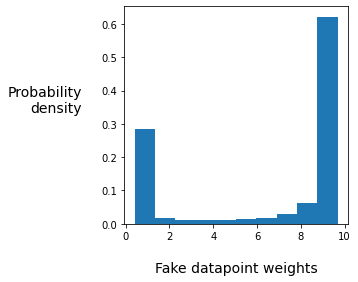

In [74]:
#  Plot distribution of weights
#

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.hist(fake_datapoint_weights, density=True)
ax.set_xlabel("Fake datapoint weights", fontsize=14, labelpad=20)
ax.set_ylabel("Probability\ndensity", fontsize=14, labelpad=20, ha="right", rotation=0)
plt.show()

In [75]:
#  Unwhiten fake datapoints
#

print("Unwhitening fake datapoints")
start = time.time()
fake_white_datapoints_unwhitened = unwhiten_axes(fake_white_datapoints, whitening_funcs)
end = time.time()
print(f"{len(fake_white_datapoints_unwhitened)} datapoints unwhitened in {int(end-start):.0f}s")


Unwhitening fake datapoints
300000 datapoints unwhitened in 8s


In [76]:
#  Compute logL at SM for generated datapoints
#

start       = time.time()
logL_NULL   = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL      = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")

test_sig = np.full (fill_value=importance_sampling_cWtil, shape=(len(fake_white_datapoints),))
start    = time.time()
logL_alt = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
L_alt    = np.exp(logL_alt)
print(f"cWtil = {importance_sampling_cWtil} logL computed in {time.time()-start:.2f}s")


SM logL computed in 17.83s
cWtil = 0.1 logL computed in 17.86s


Plotting row 0...
Plotting row 1...
Plotting row 2...
Plotting row 3...
Saving...
Showing...


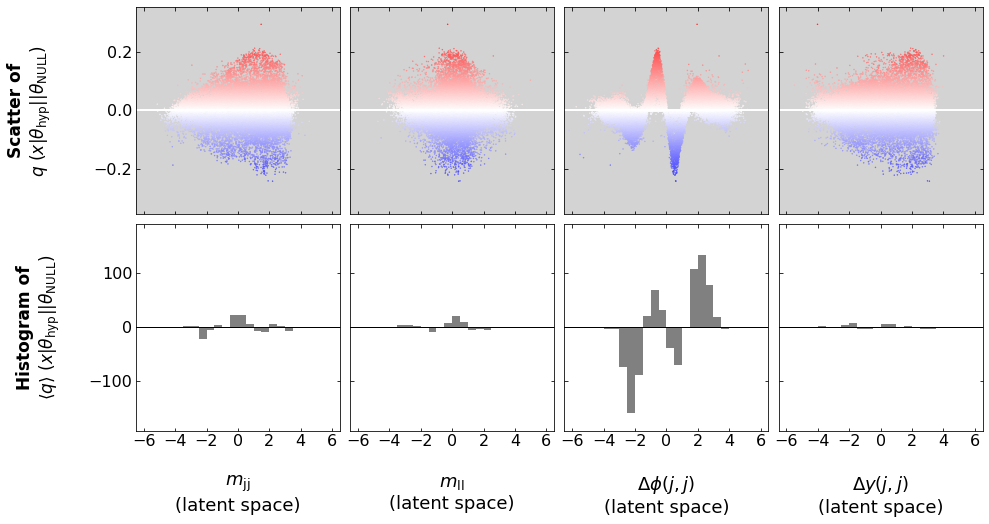

In [77]:
#  Study 1D projections of importance
#

bins=np.linspace(-6.5, 6.5, 27)
    
z_imp     = -2 * L_NULL * (logL_alt - logL_NULL)
z_imp_max = np.max(np.fabs(z_imp))
z_DLL     = -2 * (logL_alt - logL_NULL)
z_DLL_max = np.max(np.fabs(z_DLL))
hist_max  = 0
for row_idx in range(num_observables) :
    hist_vals, _ = np.histogram(fake_white_datapoints[:,row_idx], weights=fake_datapoint_weights*z_DLL, bins=bins)
    hist_max     = np.max([hist_max, np.max(np.fabs(hist_vals))])
    
sqrt_fake_datapoint_weights     = np.sqrt(fake_datapoint_weights)
sqrt_fake_datapoint_weights_max = np.max(sqrt_fake_datapoint_weights)
scatter_marker_sizes            = 0.8 * sqrt_fake_datapoint_weights / sqrt_fake_datapoint_weights_max
    
fig = plt.figure(figsize=(3*num_observables, 6))
for row_idx in range(num_observables) :
    print(f"Plotting row {row_idx}...")
    x  = fake_white_datapoints[:,row_idx]
    
    ax = fig.add_subplot(2, num_observables, row_idx + 1)
    #ax.scatter(x, z_imp, s=0.5, c=z_imp, cmap="bwr", vmin=-z_imp_max, vmax=z_imp_max)
    ax.scatter(x, z_DLL, s=scatter_marker_sizes, c=z_DLL, cmap="bwr", vmin=-z_DLL_max, vmax=z_DLL_max)
    ax.set_facecolor("lightgrey")
    ax.axhline(0, c="white", linewidth=2)
    if row_idx == 0 :
        ax.set_ylabel("Scatter of\n" + r"$q~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=41, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*z_DLL_max, 1.2*z_DLL_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    ax.get_xaxis().set_ticklabels([])
    ax.text(0.95, 1.05, "", ha="right", va="bottom")
    
    x = fake_white_datapoints[:,row_idx]
    ax = fig.add_subplot(2, num_observables, num_observables + row_idx + 1)
    ax.hist(x, weights=fake_datapoint_weights*z_DLL, bins=bins, color="grey")
    ax.axhline(0, c="black", linewidth=1)
    if row_idx == 0 : 
        ax.set_ylabel("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=27, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlabel(observables_labels[observables_order[row_idx]] +"\n(latent space)", fontsize=18, labelpad=25)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*hist_max, 1.2*hist_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.05)
print("Saving...")
#plt.savefig("figures/asimov/1D_importance_profile.pdf", bbox_inches="tight")
print("Showing...")
plt.show()
    

17.98504938485816
17.98504938485805
17.98504938485751
17.985049384858247
Plotting row 0...
Plotting row 1...
Plotting row 2...
Plotting row 3...
Saving...
Showing...


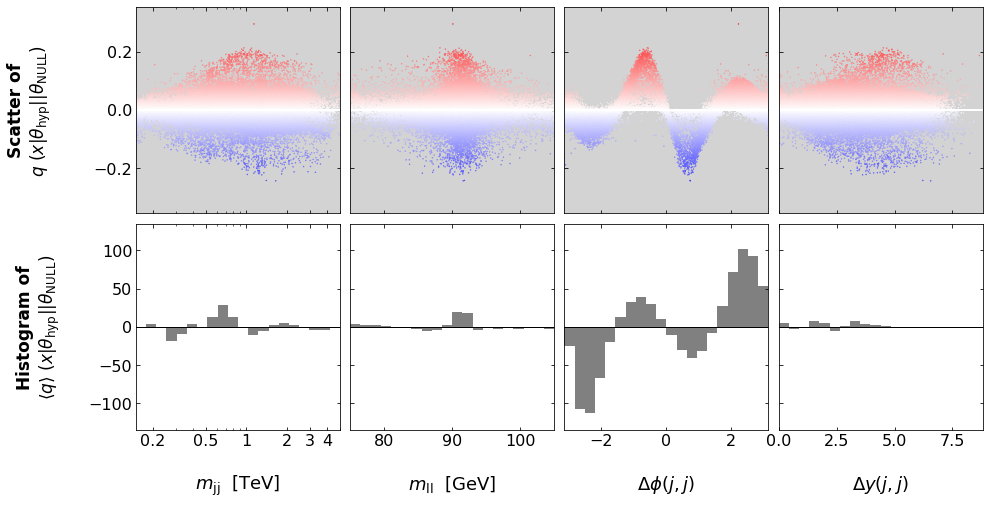

In [83]:
#  Study 1D projections of importance
#

bins_data = {}
for obs_idx in range(num_observables) :
    obs_name = observables_order[obs_idx]
    bin_lims = observable_limits[obs_name]
    if obs_idx == 0 :
        bins_data [obs_idx ] = np.logspace(np.log10(bin_lims[0]), np.log10(bin_lims[-1]), 21)
    else :
        bins_data [obs_idx ] = np.linspace(bin_lims[0], bin_lims[-1], 21)
    bins_data [obs_name] = bins_data [obs_idx]
    
hist_max_data = 0
for row_idx in range(num_observables) :
    hist_vals, _  = np.histogram(fake_white_datapoints_unwhitened[:,row_idx], weights=fake_datapoint_weights*z_DLL, bins=bins_data[row_idx])
    hist_max_data = np.max([hist_max_data, np.max(np.fabs(hist_vals))])
    print(np.sum(hist_vals))
    
    
fig = plt.figure(figsize=(3*num_observables, 6))
for row_idx in range(num_observables) :
    print(f"Plotting row {row_idx}...")
    x         = fake_white_datapoints_unwhitened[:,row_idx]
    bins_row  = bins_data [row_idx]
    obs_label = observables_labels[observables_order[row_idx]]
    if row_idx == 0 : obs_label = obs_label + "  [TeV]"
    if row_idx == 1 : obs_label = obs_label + "  [GeV]"
    
    ax = fig.add_subplot(2, num_observables, row_idx + 1)
    ax.scatter(x, z_DLL, s=scatter_marker_sizes, c=z_DLL, cmap="bwr", vmin=-z_DLL_max, vmax=z_DLL_max)
    ax.set_facecolor("lightgrey")
    ax.axhline(0, c="white", linewidth=2)
    if row_idx == 0 :
        ax.set_ylabel("Scatter of\n" + r"$q~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=41, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlim([bins_row[0], bins_row[-1]])
    ax.set_ylim(-1.2*z_DLL_max, 1.2*z_DLL_max)
    if row_idx == 0 :
        ax.set_xscale("log")
        ax.get_xaxis().set_ticks([200, 500, 1000, 2000, 3000, 4000])
    ax.get_xaxis().set_ticklabels([])
    ax.text(0.95, 1.05, "", ha="right", va="bottom")
    
    x = fake_white_datapoints_unwhitened[:,row_idx]
    ax = fig.add_subplot(2, num_observables, num_observables + row_idx + 1)
    ax.hist(x, weights=fake_datapoint_weights*z_DLL, bins=bins_row, color="grey")
    ax.axhline(0, c="black", linewidth=1)
    if row_idx == 0 : 
        ax.set_ylabel("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=27, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlabel(obs_label, fontsize=18, labelpad=25)
    ax.set_xlim([bins_row[0], bins_row[-1]])
    ax.set_ylim(-1.2*hist_max_data, 1.2*hist_max_data)
    if row_idx == 0 :
        ax.set_xscale("log")
        ax.get_xaxis().set_ticks([200, 500, 1000, 2000, 3000, 4000])
        ax.get_xaxis().set_ticklabels(["0.2", "0.5", "1", "2", "3", "4"])
    
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.05)
print("Saving...")
#plt.savefig("figures/asimov/1D_importance_profile.pdf", bbox_inches="tight")
print("Showing...")
plt.show()
    

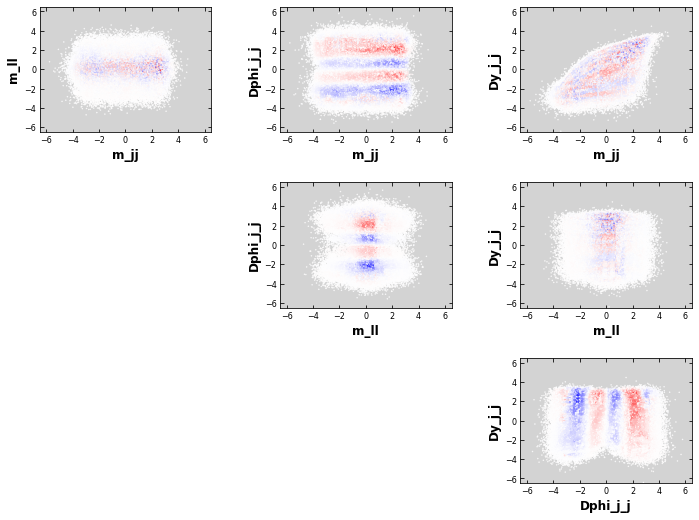

In [144]:

    
fig = plt.figure(figsize=(4*num_observables, 3*num_observables))
for row_idx in range(num_observables) :
    x = fake_white_datapoints[:,row_idx]
    for col_idx in range(row_idx+1, num_observables) :
        ax = fig.add_subplot(num_observables, num_observables, num_observables*row_idx + col_idx + 1)
        y = fake_white_datapoints[:,col_idx]
        ax.scatter(x, y, s=0.2, c=z_imp, cmap="bwr", vmin=-z_imp_max, vmax=z_imp_max)
        ax.set_facecolor("lightgrey")
        ax.set_ylabel(observables_order[col_idx], fontsize=12, weight="bold")
        ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
        ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
        ax.set_xlim([bins[0], bins[-1]])
        ax.set_ylim([bins[0], bins[-1]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


---

\begin{align}
\mathbb{E} \big[ q\left(\theta_1,\theta_0\right) \big]_{x \sim p\left(x|\theta_0\right)} ~&=~ \int^{+\infty}_{-\infty} p\left(x|\theta_0\right) ~ q\left(x;\theta_1,\theta_0\right) ~ {\rm d}x \\
&= \int^{+\infty}_{-\infty} p\left(x|\theta_0\right) ~ \left(-2\right) ~ \log \frac{p\left(x|\theta_1\right)}{p\left(x|\theta_0\right)} ~ {\rm d}x \\
&= 2 ~ D_{\rm KL}\left( p\left(x|\theta_0\right) || p\left(x|\theta_1\right) \right) \\
\end{align}

---

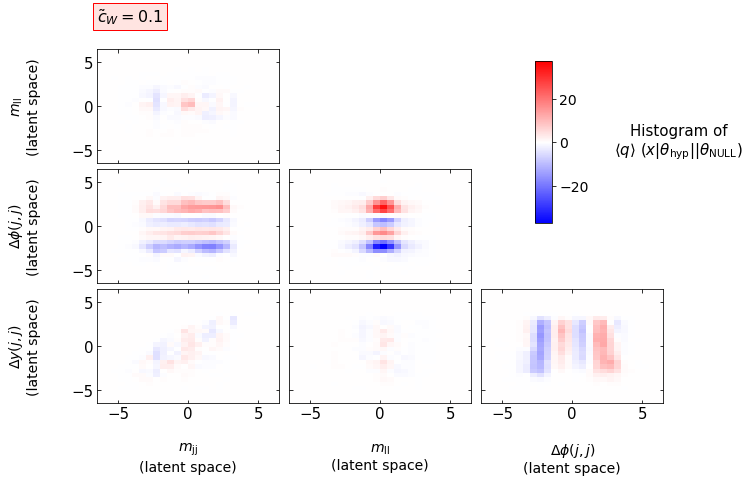

In [79]:
#  Figure out histo max
#
hist_max  = 0
for row_idx in range(num_observables) :
    for col_idx in range(row_idx+1, num_observables) :
        hist_vals, _, _ = np.histogram2d(fake_white_datapoints[:,row_idx], fake_white_datapoints[:,col_idx], weights=fake_datapoint_weights*z_DLL, bins=(bins, bins))
        hist_max        = np.max([hist_max, np.max(np.fabs(hist_vals))])
           
        
#  Figure out which observables to plot
#
observables_for_x, observables_for_y = [], []
for obs_idx_x, obs_x in enumerate(observables_order) :
    if obs_idx_x == num_observables-1 : continue
    observables_for_x.append(obs_idx_x)
    for obs_idx_y, obs_y in enumerate(observables_order) :
        if obs_idx_y == 0         : continue
        if obs_idx_y <= obs_idx_x : continue
        observables_for_y.append(obs_idx_y)
              
            
#  Make plot
#
fig = plt.figure(figsize=(8, 5))        
for obs_idx_x, obs_x in enumerate(observables_order) :
    #  Check whether we want to plot observable x
    if obs_idx_x not in observables_for_x : continue
    x = fake_white_datapoints[:,obs_idx_x]

    #  Get axis x coordinates
    xlo    = obs_idx_x / (num_observables-1)
    xwidth = 1.        / (num_observables-1)

    for obs_idx_y, obs_y in enumerate(observables_order) :

        #  Check whether we want to plot observable y
        if obs_idx_y not in observables_for_y : continue
        if obs_idx_y <= obs_idx_x : continue
        y    = fake_white_datapoints[:,obs_idx_y]

        #  Get axis y coordinates
        ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
        yheight = 1.                            / (num_observables-1)

        #  Create axis
        ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

        #  Decide whether to draw axis labels
        if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
        else : 
            ax.set_ylabel(observables_labels[obs_y] +"\n(latent space)", fontsize=14, labelpad=30)
        if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
        else : 
            ax.set_xlabel(observables_labels[obs_x] +"\n(latent space)", fontsize=14, labelpad=20)
        
        #  Format tick params
        ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

        #  Draw histogram
        ax.hist2d(x, y, weights=fake_datapoint_weights*z_DLL, bins=(bins, bins), cmap="bwr", vmin=-hist_max, vmax=hist_max)
        _, _, _, patches = ax.hist2d(x, y, weights=fake_datapoint_weights*z_DLL, bins=(bins, bins), cmap="bwr", vmin=-hist_max, vmax=hist_max)
            
        #  Set cWtil label
        if (obs_idx_x==0) and (obs_idx_y==1) :
            ax.text(0, 1.2, r"${\tilde c}_W="+f"{importance_sampling_cWtil}$", fontsize=16, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))                

cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
cbar    = fig.colorbar(patches, cax=cbar_ax)
cbar_ax.tick_params(labelsize=14)
#cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
cbar   .set_label("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=15, labelpad=90, rotation=0, va="center")

plt.savefig("figures/asimov/2D_importance_profile.pdf", bbox_inches="tight")
plt.show()
    

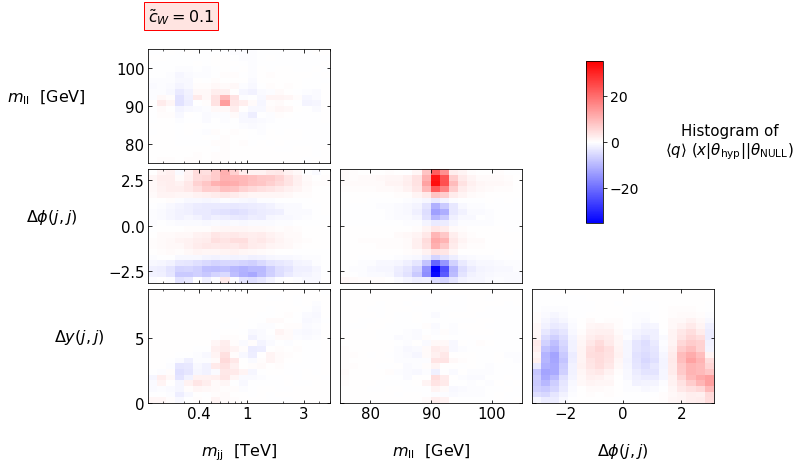

In [85]:
#  Figure out histo max
#
hist_max  = 0
for row_idx in range(num_observables) :
    bins_row  = bins_data [row_idx]
    for col_idx in range(row_idx+1, num_observables) :
        bins_col  = bins_data [col_idx]
        hist_vals, _, _ = np.histogram2d(fake_white_datapoints_unwhitened[:,row_idx], fake_white_datapoints_unwhitened[:,col_idx], weights=fake_datapoint_weights*z_DLL, bins=(bins_row, bins_col))
        hist_max        = np.max([hist_max, np.max(np.fabs(hist_vals))])
           
        
#  Figure out which observables to plot
#
observables_for_x, observables_for_y = [], []
for obs_idx_x, obs_x in enumerate(observables_order) :
    if obs_idx_x == num_observables-1 : continue
    observables_for_x.append(obs_idx_x)
    for obs_idx_y, obs_y in enumerate(observables_order) :
        if obs_idx_y == 0         : continue
        if obs_idx_y <= obs_idx_x : continue
        observables_for_y.append(obs_idx_y)
                   
            
#  Make plot
#
fig = plt.figure(figsize=(8, 5))        
for obs_idx_x, obs_x in enumerate(observables_order) :
    #  Check whether we want to plot observable x
    if obs_idx_x not in observables_for_x : continue
    x      = fake_white_datapoints_unwhitened[:,obs_idx_x]
    bins_x = bins_data [obs_idx_x]

    #  Get axis x coordinates
    xlo    = obs_idx_x / (num_observables-1)
    xwidth = 1.        / (num_observables-1)
    
    #  Get axis x label
    obs_label_x = observables_labels[observables_order[obs_idx_x]]
    if obs_idx_x == 0 : obs_label_x = obs_label_x + "  [TeV]"
    if obs_idx_x == 1 : obs_label_x = obs_label_x + "  [GeV]"

    for obs_idx_y, obs_y in enumerate(observables_order) :

        #  Check whether we want to plot observable y
        if obs_idx_y not in observables_for_y : continue
        if obs_idx_y <= obs_idx_x : continue
        y      = fake_white_datapoints_unwhitened[:,obs_idx_y]
        bins_y = bins_data [obs_idx_y]

        #  Get axis y coordinates
        ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
        yheight = 1.                            / (num_observables-1)
    
        #  Get axis y label
        obs_label_y = observables_labels[observables_order[obs_idx_y]]
        if obs_idx_y == 0 : obs_label_y = obs_label_y + "  [TeV]"
        if obs_idx_y == 1 : obs_label_y = obs_label_y + "  [GeV]"

        #  Create axis
        ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

        #  Decide whether to draw axis labels
        if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
        else : 
            ax.set_ylabel(obs_label_y, fontsize=16, labelpad=30, rotation=0, ha="right")
        if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
        else : 
            ax.set_xlabel(obs_label_x, fontsize=16, labelpad=20)
        
        #  Format tick params
        ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

        #  Draw histogram
        _, _, _, patches = ax.hist2d(x, y, weights=fake_datapoint_weights*z_DLL, bins=(bins_x, bins_y), cmap="bwr", vmin=-hist_max, vmax=hist_max)
            
        #  Draw cWtil label
        if (obs_idx_x==0) and (obs_idx_y==1) :
            ax.text(0, 1.2, r"${\tilde c}_W="+f"{importance_sampling_cWtil}$", fontsize=16, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                
        #  If mjj axis, make it log and with better labels
        if (obs_idx_x==0) :
            ax.set_xscale("log")
            ax.get_xaxis().set_ticks([400, 1000, 3000])
            if obs_idx_y == num_observables-1 : 
                ax.get_xaxis().set_ticklabels(["0.4", "1", "3"])
            else : 
                ax.get_xaxis().set_ticklabels([])
            

cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
cbar    = fig.colorbar(patches, cax=cbar_ax)
cbar_ax.tick_params(labelsize=14)
#cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
cbar   .set_label("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=15, labelpad=90, rotation=0, va="center")

plt.savefig("figures/asimov/2D_importance_profile_unwhitened.pdf", bbox_inches="tight")
plt.show()
    

In [146]:

#sample_density_models(100000, 100000, 0.98) 

start       = time.time()
#yp_NULL     = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
yp_NULL     = logL_NULL
print(f"SM logL computed in {time.time()-start:.2f}s")

start       = time.time()
test_sig    = np.full(fill_value=importance_sampling_cWtil, shape=(len(fake_white_datapoints),))
#yp          = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
yp          = logL_alt
print(f"cWtil = {importance_sampling_cWtil:.4f} logL computed in {time.time()-start:.2f}s")

p0_x_DLL       = fake_datapoint_weights * np.fabs(yp-yp_NULL)
data_to_fit    = {0: fake_white_datapoints}
weights_to_fit = {0: p0_x_DLL             }

SM logL computed in 0.00s
cWtil = 0.1500 logL computed in 0.00s


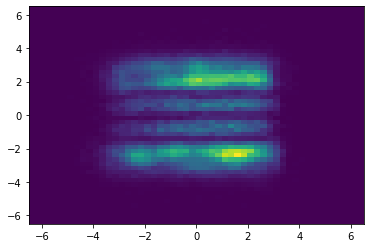

In [147]:
#  Plot training data to make sure we understand it
#

plt.hist2d(fake_white_datapoints[:,0], fake_white_datapoints[:,2], weights=p0_x_DLL, bins=np.linspace(-6.5, 6.5, 53))
plt.show()

In [148]:
density_model.Gauss_width_reduction_factor = 2.

range_limits = {}
for idx in range(num_observables) :
    range_limits[idx] = [np.min(fake_white_datapoints), np.max(fake_white_datapoints)]

density_model_TNLL = DensityModel(name            = "asimov_sampling_model", 
                                  num_gaussians   = 15, 
                                  num_conditions  = 1, 
                                  num_observables = num_observables, 
                                  types           = observables_types,
                                  int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(observables_order, observables_types)) if t == int},
                                  verbose         = True,
                                  learning_rate   = 0.001,
                                  optimiser       = "adam",
                                  range_limits    = range_limits)

density_model_TNLL.fit(data_to_fit, 
                      weights_to_fit,
                      observable                = [i for i in range(num_observables)],
                      max_epochs_per_observable = 1,
                      early_stopping_patience   = 5,
                      early_stopping_min_delta  = 0,
                      validation_split          = 0.5,
                      batch_size_per_observable = 1000)

density_model_TNLL.fit(data_to_fit, 
                      weights_to_fit,
                      observable                = [i for i in range(num_observables)],
                      max_epochs_per_observable = 1000,
                      early_stopping_patience   = 5,
                      early_stopping_min_delta  = 0,
                      validation_split          = 0.5,
                      batch_size_per_observable = 1000)
    

INFO       DensityModel.construct      Set model name           : asimov_sampling_model
INFO       DensityModel.construct      Set model num_gaussians  : 15
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer   : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer     : zeros
INFO       DensityModel.build          Building model segment: asimov_sampling_model_observable0 for observable index 0
Creating continuous density model: asimov_sampling_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 15
  - range              is -6.4160 - 5.7839
  - kernel_initializer is glorot_uniform
  - bias_initializer   is zeros
Model: "asimov_sampling_model

Model: "asimov_sampling_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_215 (Dense)               (None, 7)            14          input_48[0][0]                   
__________________________________________________________________________________________________
dense_216 (Dense)               (None, 6)            18          input_49[0][0]                   
__________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 4s 19us/sample - loss: 0.0045 - val_loss: 0.0040
Fit completed in 11s
INFO       DensityModel.fit            Training observable index 1
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit           

Epoch 6/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 7/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 8/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 9/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 10/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 11/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 12/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 13/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 14/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch

Epoch 41/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 42/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 43/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 44/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 45/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 46/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 47/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 48/1000
200000/200000 [==============================] - 1s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 49/1000
200000/200000 [==============================] - 1s 7us/sample - loss: 0.0029 - val_loss: 0.0029
E

In [149]:

#  Keras calculation of Sampling log-likelihood for set of datapoints
#
def K_get_log_likelihood_sampling (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, 15)


#  Get lists of sampling density models
#
sampling_models = [x.model for x in density_model_TNLL.likelihood_models]


#  Split inputs and pipe them through individual layers of the EWK and QCD density models
#  -  each one models a separate conditional probability, to be combined afterwards
#
sampling_logL_layers = []
for i, sampling_model in enumerate(sampling_models) :
    model_inputs = [condition_input_layer_cWtil]
    if i > 0 :
        cond_obs_split_layer = Lambda(lambda x : x[:, :i], name=f"split_observable_below{i}_sampling")(obs_input_layer)
        model_inputs.append(cond_obs_split_layer)
    sampling_params = sampling_model(model_inputs)
    eval_p          = Lambda(lambda x : x[:, i], name=f"split_observable_eq{i}_sampling")(obs_input_layer)
    sampling_logL_layers.append(Lambda(K_get_log_likelihood_sampling, name=f"Sampling_logL_observable{i}")([eval_p, sampling_params]))

    
#  Keras Lambda layers to perform conditional probability combination
#
Sampling_logL = Lambda(lambda x : tf.add_n(x), name="Sampling_logL_total")(sampling_logL_layers)


#  Build Sampling_logL_model logL model combining layers
#
Sampling_logL_model = Model([condition_input_layer_cWtil, obs_input_layer], Sampling_logL)
Sampling_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam")


In [150]:
#  Importance sample a new Asimov dataset
#

start = time.time()
print("Sampling datapoints")
probe_ds = density_model_TNLL.sample(n_asimov, [0])
print(f"Datapoints sampled in {int(time.time()-start):.0f}s")


Sampling datapoints
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 3
Datapoints sampled in 556s


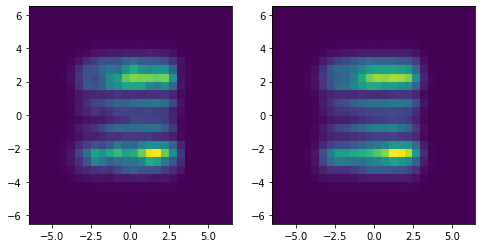

In [151]:
#  Plot training & sampled data to see whether we did a good job training the model
#

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1)
ax.hist2d(fake_white_datapoints[:,0], fake_white_datapoints[:,2], weights=p0_x_DLL, bins=bins)

ax = fig.add_subplot(1, 2, 2)
ax.hist2d(probe_ds[:,0], probe_ds[:,2], bins=bins)

plt.show()

In [152]:
#  Get sampling proabability for sampling datapoints
#  -  this is the denominator in importance sampling weight
#

dummy_zeros_probe = np.zeros(shape=len(probe_ds))

start = time.time()
print("Getting sampling probability for all sampled datapoints")
probe_pdf = np.exp(Sampling_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0))
print(f"Datapoints evaluated in {int(time.time()-start):.0f}s")


Getting sampling probability for all sampled datapoints
Datapoints evaluated in 65s


In [153]:

start = time.time()
print("Evaluating QCD density")
QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
print(f"datapoints evaluated in {int(time.time()-start):.0f}s")

start = time.time()
print("Evaluating EWK density")
EWK_logL_probe = EWK_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
print(f"datapoints evaluated in {int(time.time()-start):.0f}s")

QCD_L_probe = np.exp(QCD_logL_probe)
EWK_L_probe = np.exp(EWK_logL_probe)

Evaluating QCD density
datapoints evaluated in 77s
Evaluating EWK density
datapoints evaluated in 76s


In [154]:
print([x for x in QCD_L_probe if np.isnan(x) or np.isinf(x)])
print([x for x in EWK_L_probe if np.isnan(x) or np.isinf(x)])

[]
[]


In [155]:

reweight_pdf  = (sigma_EWK*EWK_L_probe + sigma_QCD*QCD_L_probe) / sigma_tot
probe_weights = L * sigma_tot * reweight_pdf / (probe_pdf * len(probe_ds))

In [156]:
#  Remove events with 0 weight

filtered_datapoints = [(x1, x2, x3, x4, x5, x6, x7, x9) for x1, x2, x3, x4, x5, x6, x7, x8, x9 in zip(probe_ds, probe_pdf, QCD_logL_probe, EWK_logL_probe, QCD_L_probe, EWK_L_probe, reweight_pdf, np.log(reweight_pdf), probe_weights) if not np.isinf(x8)]
print(f"{len(filtered_datapoints)} datapoints survived")
probe_ds       = np.array([x[0] for x in filtered_datapoints])
probe_pdf      = np.array([x[1] for x in filtered_datapoints])
QCD_logL_probe = np.array([x[2] for x in filtered_datapoints])
EWK_logL_probe = np.array([x[3] for x in filtered_datapoints])
QCD_L_probe    = np.array([x[4] for x in filtered_datapoints])
EWK_L_probe    = np.array([x[5] for x in filtered_datapoints])
reweight_pdf   = np.array([x[6] for x in filtered_datapoints])
probe_weights  = np.array([x[7] for x in filtered_datapoints])

dummy_zeros_probe = np.zeros(shape=len(probe_ds))
                       

1000000 datapoints survived


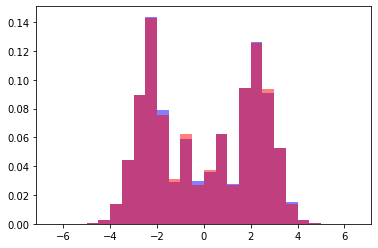

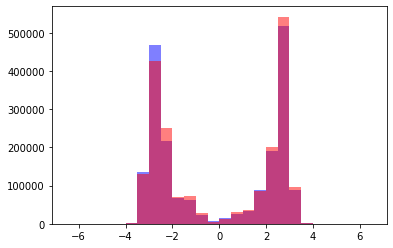

In [157]:
plt.hist(fake_white_datapoints[:,2], weights=p0_x_DLL/np.sum(p0_x_DLL), bins=bins, alpha=0.5, color="b")
plt.hist(probe_ds[:,2], weights=[1/len(probe_ds) for i in range(len(probe_ds))], bins=bins, alpha=0.5, color="r")
plt.show()

plt.hist(fake_white_datapoints[:,2], weights=fake_datapoint_weights, bins=bins, alpha=0.5, color="b")
plt.hist(probe_ds[:,2], weights=probe_weights, bins=bins, alpha=0.5, color="r")
plt.show()

In [158]:

yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, probe_ds], verbose=0))
print([x for x in yp_NULL if np.isnan(x) or np.isinf(x)])
print([x for x in probe_weights if np.isnan(x) or np.isinf(x)])
TNLL_NULL = np.sum(np.longdouble(probe_weights)*yp_NULL)
print(f"TNLL_NULL = {TNLL_NULL}")

profile_x_big = np.linspace(-0.1, 0.1, 21)
profile_y_big = []
for x in profile_x_big :
    sys.stdout.write(f"\nx = {x:.3f}")
    test_sig = np.ones (shape=(len(probe_ds),)) * x
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, probe_ds], verbose=0))
    TNLL = -2 * (np.sum(np.longdouble(probe_weights)*(yp-yp_NULL))) # + TNLL_NULL)
    sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
    profile_y_big.append(TNLL)
    

[]
[]
TNLL_NULL = -4958076.932092657

x = -0.100  y = 13.170
x = -0.090  y = 10.680
x = -0.080  y = 8.436
x = -0.070  y = 6.470
x = -0.060  y = 4.752
x = -0.050  y = 3.286
x = -0.040  y = 2.100
x = -0.030  y = 1.188
x = -0.020  y = 0.528
x = -0.010  y = 0.133
x = 0.000  y = -0.000
x = 0.010  y = 0.102
x = 0.020  y = 0.471
x = 0.030  y = 1.077
x = 0.040  y = 1.913
x = 0.050  y = 3.045
x = 0.060  y = 4.450
x = 0.070  y = 6.084
x = 0.080  y = 7.980
x = 0.090  y = 10.126
x = 0.100  y = 12.534

In [61]:
chi2_vals = np.linspace(0, 8, 201)
chi2_cdf  = scipy.stats.chi2.cdf(chi2_vals, df=1)

contour_lvls = np.array([68, 95, 99])
contour_vals = np.interp(0.01*contour_lvls, chi2_cdf, chi2_vals)

for lvl, val in zip(contour_lvls, contour_vals) :
    print(f"{lvl}% p-value level at chi2 = {val:.4f}")
    

68% p-value level at chi2 = 0.9891
95% p-value level at chi2 = 3.8415
99% p-value level at chi2 = 6.6349


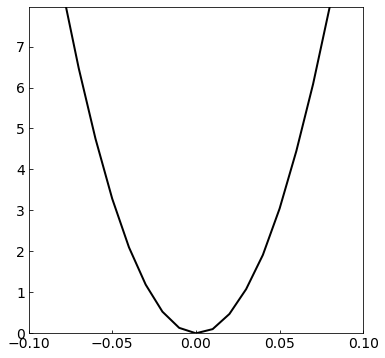

In [160]:

fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(profile_x_big, profile_y_big-np.min(profile_y_big), "-", linewidth=2, c="k")
ax.set_ylim([0, 1.2*contour_vals[-1]])
ax.set_xlim(profile_x_big[0], profile_x_big[-1])
ax.tick_params(which="both", direction="in", labelsize=14)
plt.show()


Creating new asimov for toy index 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 60s
Evaluating sampling PDF
  - completed in 6s
Getting QCD and EWK PDFs for reweighting
  - completed in 16s
Getting TNLL at minimum
  - completed in 8s
Scanning likelihood

x = -0.100  y = 6.520
x = -0.095  y = 5.602
x = -0.090  y = 4.703
x = -0.085  y = 3.871
x = -0.080  y = 3.136
x = -0.075  y = 2.459
x = -0.070  y = 1.831
x = -0.065  y = 1.291
x = -0.060  y = 0.818
x = -0.055  y = 0.381
x = -0.050  y = 0.025
x = -0.045  y = -0.250
x = -0.040  y = -0.451
x = -0.035  y = -0.600
x = -0.030  y = -0.701
x = -0.025  y = -0.717
x = -0.020  y = -0.681
x = -0.015  y = -0.596
x = -0.010  

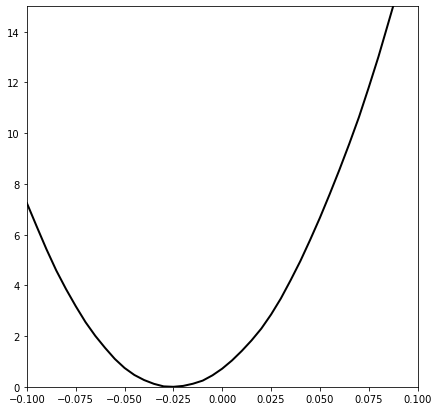


Creating new asimov for toy index 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 58s
Evaluating sampling PDF
  - completed in 6s
Getting QCD and EWK PDFs for reweighting
  - completed in 15s
Getting TNLL at minimum
  - completed in 7s
Scanning likelihood

x = -0.100  y = 11.315
x = -0.095  y = 10.142
x = -0.090  y = 8.991
x = -0.085  y = 7.927
x = -0.080  y = 6.943
x = -0.075  y = 6.010
x = -0.070  y = 5.153
x = -0.065  y = 4.332
x = -0.060  y = 3.595
x = -0.055  y = 2.918
x = -0.050  y = 2.321
x = -0.045  y = 1.765
x = -0.040  y = 1.284
x = -0.035  y = 0.887
x = -0.030  y = 0.556
x = -0.025  y = 0.288
x = -0.020  y = 0.092
x = -0.015  y = -0.022
x = -0.010  y = 

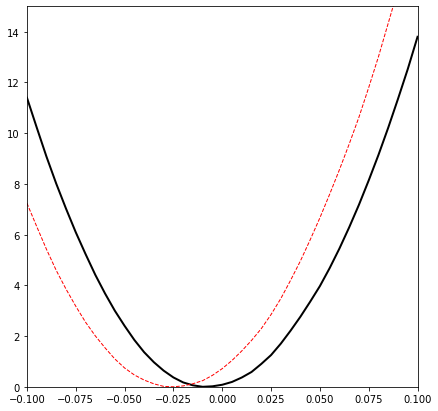


Creating new asimov for toy index 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 53s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 13s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 10.119
x = -0.095  y = 9.017
x = -0.090  y = 7.955
x = -0.085  y = 6.978
x = -0.080  y = 6.049
x = -0.075  y = 5.221
x = -0.070  y = 4.414
x = -0.065  y = 3.677
x = -0.060  y = 3.029
x = -0.055  y = 2.424
x = -0.050  y = 1.877
x = -0.045  y = 1.425
x = -0.040  y = 1.020
x = -0.035  y = 0.689
x = -0.030  y = 0.414
x = -0.025  y = 0.169
x = -0.020  y = 0.022
x = -0.015  y = -0.069
x = -0.010  y = -

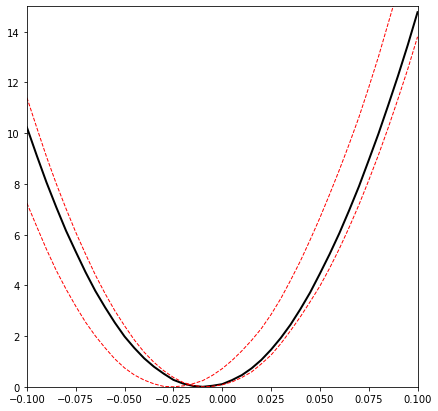


Creating new asimov for toy index 3
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 54s
Evaluating sampling PDF
  - completed in 6s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 11.838
x = -0.095  y = 10.673
x = -0.090  y = 9.551
x = -0.085  y = 8.498
x = -0.080  y = 7.503
x = -0.075  y = 6.579
x = -0.070  y = 5.725
x = -0.065  y = 4.927
x = -0.060  y = 4.198
x = -0.055  y = 3.541
x = -0.050  y = 2.931
x = -0.045  y = 2.358
x = -0.040  y = 1.850
x = -0.035  y = 1.404
x = -0.030  y = 1.027
x = -0.025  y = 0.708
x = -0.020  y = 0.466
x = -0.015  y = 0.226
x = -0.010  y = 0

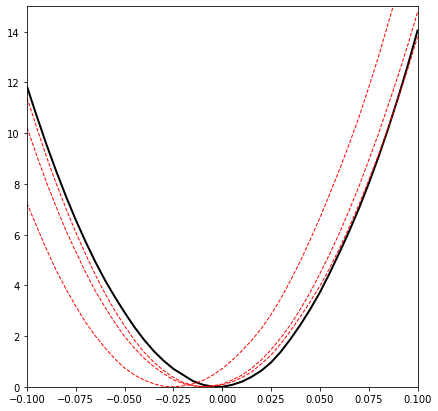


Creating new asimov for toy index 4
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 54s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 16.865
x = -0.095  y = 15.424
x = -0.090  y = 14.012
x = -0.085  y = 12.673
x = -0.080  y = 11.388
x = -0.075  y = 10.193
x = -0.070  y = 9.026
x = -0.065  y = 7.946
x = -0.060  y = 6.933
x = -0.055  y = 5.972
x = -0.050  y = 5.082
x = -0.045  y = 4.283
x = -0.040  y = 3.544
x = -0.035  y = 2.874
x = -0.030  y = 2.267
x = -0.025  y = 1.721
x = -0.020  y = 1.244
x = -0.015  y = 0.845
x = -0.010  y

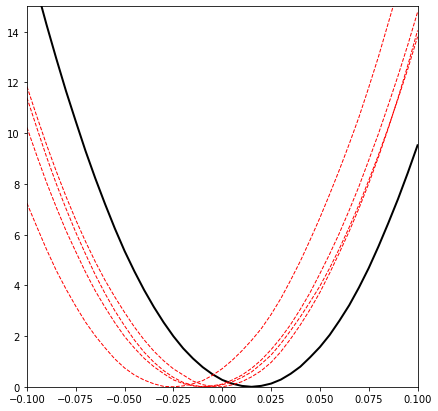


Creating new asimov for toy index 5
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 54s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 8.911
x = -0.095  y = 7.840
x = -0.090  y = 6.830
x = -0.085  y = 5.856
x = -0.080  y = 4.960
x = -0.075  y = 4.137
x = -0.070  y = 3.394
x = -0.065  y = 2.703
x = -0.060  y = 2.088
x = -0.055  y = 1.519
x = -0.050  y = 1.045
x = -0.045  y = 0.640
x = -0.040  y = 0.296
x = -0.035  y = 0.020
x = -0.030  y = -0.206
x = -0.025  y = -0.352
x = -0.020  y = -0.424
x = -0.015  y = -0.420
x = -0.010  y =

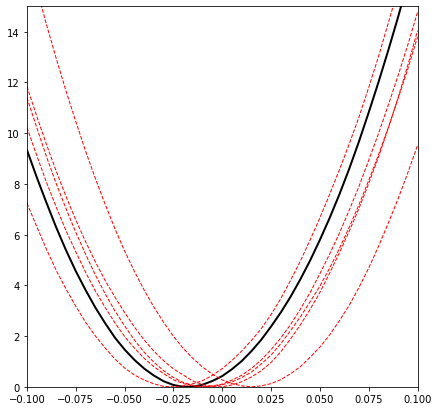


Creating new asimov for toy index 6
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 54s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 18.223
x = -0.095  y = 16.745
x = -0.090  y = 15.273
x = -0.085  y = 13.895
x = -0.080  y = 12.595
x = -0.075  y = 11.361
x = -0.070  y = 10.166
x = -0.065  y = 9.032
x = -0.060  y = 7.954
x = -0.055  y = 6.931
x = -0.050  y = 5.965
x = -0.045  y = 5.095
x = -0.040  y = 4.258
x = -0.035  y = 3.488
x = -0.030  y = 2.797
x = -0.025  y = 2.166
x = -0.020  y = 1.606
x = -0.015  y = 1.119
x = -0.010  

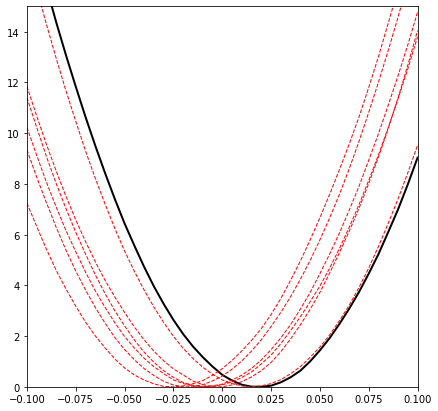


Creating new asimov for toy index 7
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 54s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 14.853
x = -0.095  y = 13.523
x = -0.090  y = 12.227
x = -0.085  y = 11.009
x = -0.080  y = 9.861
x = -0.075  y = 8.772
x = -0.070  y = 7.737
x = -0.065  y = 6.779
x = -0.060  y = 5.862
x = -0.055  y = 5.010
x = -0.050  y = 4.202
x = -0.045  y = 3.475
x = -0.040  y = 2.813
x = -0.035  y = 2.210
x = -0.030  y = 1.683
x = -0.025  y = 1.220
x = -0.020  y = 0.857
x = -0.015  y = 0.540
x = -0.010  y =

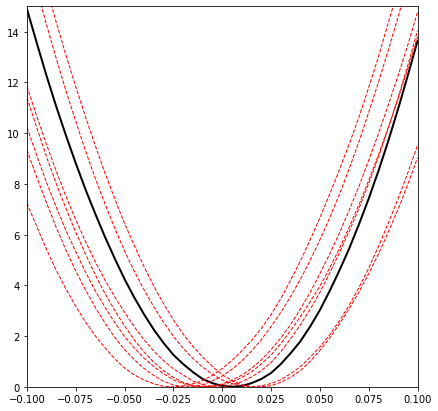


Creating new asimov for toy index 8
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 55s
Evaluating sampling PDF
  - completed in 5s
Getting QCD and EWK PDFs for reweighting
  - completed in 14s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 6.286
x = -0.095  y = 5.353
x = -0.090  y = 4.468
x = -0.085  y = 3.629
x = -0.080  y = 2.874
x = -0.075  y = 2.182
x = -0.070  y = 1.549
x = -0.065  y = 0.976
x = -0.060  y = 0.493
x = -0.055  y = 0.040
x = -0.050  y = -0.308
x = -0.045  y = -0.588
x = -0.040  y = -0.813
x = -0.035  y = -0.954
x = -0.030  y = -0.999
x = -0.025  y = -0.999
x = -0.020  y = -0.946
x = -0.015  y = -0.809
x = -0.010 

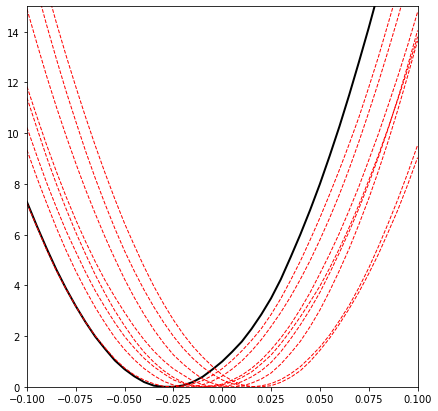


Creating new asimov for toy index 9
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
  - completed in 56s
Evaluating sampling PDF
  - completed in 6s
Getting QCD and EWK PDFs for reweighting
  - completed in 15s
Getting TNLL at minimum
  - completed in 6s
Scanning likelihood

x = -0.100  y = 9.835
x = -0.095  y = 8.704
x = -0.090  y = 7.615
x = -0.085  y = 6.610
x = -0.080  y = 5.668
x = -0.075  y = 4.850
x = -0.070  y = 4.076
x = -0.065  y = 3.353
x = -0.060  y = 2.724
x = -0.055  y = 2.138
x = -0.050  y = 1.619
x = -0.045  y = 1.165
x = -0.040  y = 0.768
x = -0.035  y = 0.421
x = -0.030  y = 0.157
x = -0.025  y = -0.049
x = -0.020  y = -0.191
x = -0.015  y = -0.240
x = -0.010  y = 

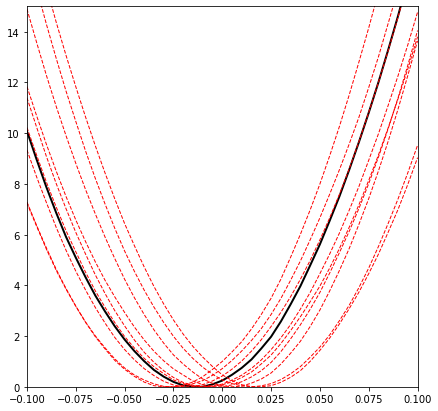

In [165]:
n_asimov_toy      = int(1e5)
num_toys          = 10
dummy_zeros_probe = np.zeros(shape=(n_asimov_toy,))

profile_x_100k  = np.linspace(-0.1, 0.1, 41)
profiles_y_100k = []
for toy_idx in range(num_toys) :  
    print(f"\nCreating new asimov for toy index {toy_idx}")
    start = time.time()
    probe_ds  = density_model_TNLL.sample(n_asimov_toy, [0])
    print(f"  - completed in {int(time.time()-start):.0f}s")
    
    print("Evaluating sampling PDF")
    start = time.time()
    probe_pdf = np.exp(Sampling_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0))
    print(f"  - completed in {int(time.time()-start):.0f}s")
    
    print("Getting QCD and EWK PDFs for reweighting")
    start = time.time()
    QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
    EWK_logL_probe = EWK_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
    QCD_L_probe = np.exp(QCD_logL_probe)
    EWK_L_probe = np.exp(EWK_logL_probe)
    reweight_pdf  = (sigma_EWK*EWK_L_probe + sigma_QCD*QCD_L_probe) / sigma_tot
    probe_weights = L * sigma_tot * reweight_pdf / (probe_pdf * len(probe_ds))
    print(f"  - completed in {int(time.time()-start):.0f}s")

    print("Getting TNLL at minimum")
    start = time.time()
    yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, probe_ds], verbose=0))
    TNLL_NULL = np.sum(np.longdouble(probe_weights)*yp_NULL)
    print(f"  - completed in {int(time.time()-start):.0f}s")

    print("Scanning likelihood")
    start = time.time()
    profile_y_100k = []
    for x in profile_x :
        sys.stdout.write(f"\nx = {x:.3f}")
        test_sig = np.ones (shape=(len(probe_ds),)) * x
        yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, probe_ds], verbose=0))
        TNLL = -2 * (np.sum(np.longdouble(probe_weights)*(yp-yp_NULL)))
        sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
        profile_y_100k.append(TNLL)
    print(f"  - completed in {int(time.time()-start):.0f}s")
        
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(1, 1, 1)
    ax.plot(profile_x_100k, profile_y_100k-np.min(profile_y_100k), "-", linewidth=2, c="k")
    for other_y_100k in profiles_y_100k :
        ax.plot(profile_x_100k, other_y_100k-np.min(other_y_100k), "--", linewidth=1, c="r")
    ax.set_ylim([0, 15])
    ax.set_xlim(profile_x_100k[0], profile_x_100k[-1])
    plt.show()
    profiles_y_100k.append(profile_y_100k)
    

In [95]:
#  Define function which cuts off the Asimov curve at the highest point
#  -  assumes convex curve, otherwise will break
#

def cut_off_curve (x, y, lvl=None) :
    assert len(x) == len(y)
    num_pts = len(x)
    if type(lvl) == type(None) :
        lvl = contour_vals[-1]
    x_new, y_new = [], []
    for i in range(num_pts-1) :
        xp, yp, xpn, ypn = x[i], y[i], x[i+1], y[i+1]
        if yp < lvl :
            x_new.append(xp)
            y_new.append(yp)
            continue
        if len(x_new) == 0 :
            if (ypn > lvl) : continue
            x_new.append(np.interp(lvl, [ypn, yp], [xpn, xp]))
            y_new.append(lvl) 
        if y_new[-1] == lvl :
            continue
        x_new.append(np.interp(lvl, [y_new[-1], yp], [x_new[-1], xp]))
        y_new.append(lvl)
    xp, yp, xpl, ypl = x[-1], y[-1], x[-2], y[-2]
    if ypl < lvl :
        if yp < lvl :
            x_new.append(xp)
            y_new.append(yp)
        else :
            x_new.append(np.interp(lvl, [ypl, yp], [xpl, xp]))
            y_new.append(lvl)
    return x_new, y_new

def plot_trimmed_curve (ax, x, y, *argv, **kwargs) :
    y = y - np.min(y)
    lvl = contour_vals[-1]
    x, y = cut_off_curve (x, y, lvl)
    xv   = [xp for xp, yp in zip(x,y) if yp < lvl]
    yv   = [yp for xp, yp in zip(x,y) if yp < lvl]
    ax.plot(xv, yv, "o", **{arg:v for arg,v in kwargs.items() if arg != "label"})
    ax.plot(x , y , "-", **kwargs)
    
def get_lims (x, y, lvl=None) :
    assert len(x) == len(y)
    if type(lvl) == type(None) :
        lvl = contour_vals[1]
    lower, upper = None, None
    for i in range(len(x)-1) :
        xp, yp, xpn, ypn = x[i], y[i], x[i+1], y[i+1]
        if (yp > lvl) and (ypn < lvl) :
            lower = np.interp(lvl, [ypn, yp], [xpn, xp])
        if (yp < lvl) and (ypn > lvl) :
            upper = np.interp(lvl, [yp, ypn], [xp, xpn])
    return lower, upper
    

s_100k ~ 0.0150
s_1M   ~ 0.0047


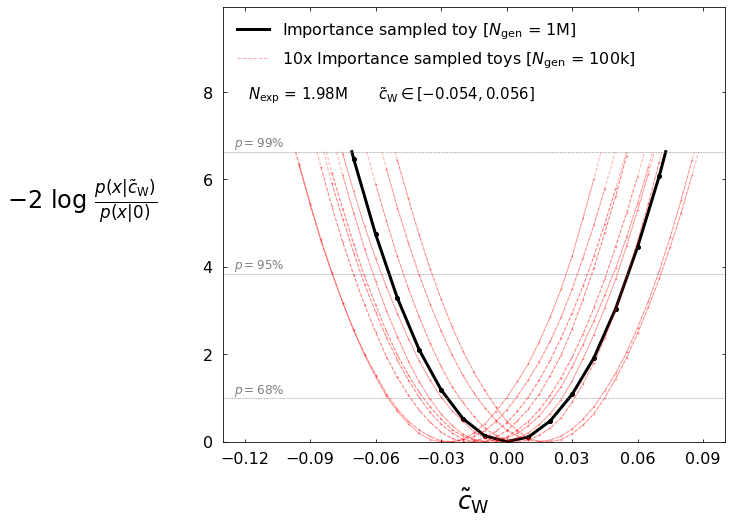

In [293]:
#  Plot Asimov scan and pull out limits
#

limits_65pct = get_lims(profile_x_big, profile_y_big)

fig = plt.figure(figsize=(9, 8))
ax  = fig.add_subplot(1, 1, 1)

plot_trimmed_curve(ax, profile_x_big, profile_y_big, c="k", markersize=4, linewidth=3, label=r"Importance sampled toy [$N_{\rm gen}$ = 1M]")

x_best = []
for idx, profile_y_100k in enumerate(profiles_y_100k) :
    label = r"10x Importance sampled toys [$N_{\rm gen}$ = 100k]" if idx == 0 else None
    plot_trimmed_curve(ax, profile_x_100k, profile_y_100k, c="r", markersize=1, linewidth=1, linestyle="--", alpha=0.3, label=label)
    x_best.append([xp for xp,yp in zip(profile_x_100k, profile_y_100k) if yp == np.min(profile_y_100k)][0])

print(f"s_100k ~ {np.std(x_best):.4f}")
print(f"s_1M   ~ {np.std(x_best)/np.sqrt(10):.4f}")

for lvl, val in zip(contour_lvls, contour_vals) :
    ax.axhline(val, linestyle="--", linewidth=0.5, color="gray")
    ax.text(-0.125, val, f"$p = {lvl}\%$", ha="left", va="bottom", fontsize=12, color="gray")
    
ax.set_xlim([-0.13, 0.1])
ax.set_ylim([0, 1.5*contour_vals[-1]])

ax.set_xticks([-0.12, -0.09, -0.06, -0.03, 0, 0.03, 0.06, 0.09])
ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16, pad=10)
ax.legend(loc="upper left", fontsize=16, frameon=False)

ax.set_xlabel(r"${\tilde c}_{\rm W}$", fontsize=25, labelpad=20)
ax.set_ylabel(r"$-2~\log~\frac{p(x|{\tilde c}_{\rm W})}{p(x|0)}$", fontsize=24, labelpad=120, rotation=0)

ax.text(0.05, 0.82, r"$N_{\rm exp}$ = " + f"{L*sigma_tot/1e6:.2f}M", transform=ax.transAxes, ha="left", va="top", fontsize=15)
ax.text(0.31, 0.82, r"${\tilde c}_{\rm W} \in [" + f"{limits_65pct[0]:.3f}, {limits_65pct[1]:.3f}]$", transform=ax.transAxes, ha="left", va="top", fontsize=15)

plt.savefig("figures/asimov/asimov_scan.pdf", bbox_inches="tight")
plt.show()



---

### Cross-check: Toy with no importance sampling

---

In [55]:
#  Create a dataset to study
#
n_gen_EWK_toy = int(sigma_EWK*L)
n_gen_QCD_toy = int(sigma_QCD*L)

print(f"n_gen_EWK_toy = {n_gen_EWK_toy}")
print(f"n_gen_QCD_toy = {n_gen_QCD_toy}")

sample_density_models(n_gen_EWK_toy, n_gen_QCD_toy, False) 

print(f"mean of weights is {np.mean(fake_datapoint_weights)}")
print(f"std  of weights is {np.std (fake_datapoint_weights)}")


n_gen_EWK_toy = 40625
n_gen_QCD_toy = 1935944
Generating 40625 fake EWK datapoints
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 3
40625 EWK datapoints generated at cWtil=0 in 24s
Computing QCD logL for generated datapoints
QCD logL computed in 1.57s
Computing EWK logL for generated datapoints
EWK logL computed in 1.99s
Generating 1935944 fake QCD datapoints
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1935944 datapoint

In [56]:
dummy_zeros_probe = np.zeros(shape=len(fake_white_datapoints))

start = time.time()
print("Evaluating QCD density")
QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, fake_white_datapoints], verbose=0)
print(f"datapoints evaluated in {int(time.time()-start):.0f}s")

Evaluating QCD density
datapoints evaluated in 94s


In [58]:

yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, fake_white_datapoints], verbose=0))
print([x for x in yp_NULL if np.isnan(x) or np.isinf(x)])
TNLL_NULL = np.sum(np.longdouble(fake_datapoint_weights)*yp_NULL)
print(f"TNLL_NULL = {TNLL_NULL}")
  

[]
TNLL_NULL = -5009926.735288917


In [59]:
profile_x_toy = np.linspace(-0.1, 0.1, 21)
profile_y_toy = []
for x in profile_x_toy :
    sys.stdout.write(f"\nx = {x:.3f}")
    test_sig = np.ones (shape=(len(fake_white_datapoints),)) * x
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, fake_white_datapoints], verbose=0))
    TNLL = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL))) # + TNLL_NULL)
    sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
    profile_y_toy.append(TNLL)


x = -0.100  y = 7.041
x = -0.090  y = 5.147
x = -0.080  y = 3.511
x = -0.070  y = 2.162
x = -0.060  y = 1.048
x = -0.050  y = 0.190
x = -0.040  y = -0.419
x = -0.030  y = -0.719
x = -0.020  y = -0.725
x = -0.010  y = -0.490
x = 0.000  y = -0.000
x = 0.010  y = 0.743
x = 0.020  y = 1.710
x = 0.030  y = 2.899
x = 0.040  y = 4.304
x = 0.050  y = 5.968
x = 0.060  y = 7.871
x = 0.070  y = 9.983
x = 0.080  y = 12.357
x = 0.090  y = 15.010
x = 0.100  y = 17.893

In [86]:

profile_y_extra_toys = []

for i in range(100) : 
    try :
        sample_density_models(n_gen_EWK_toy, n_gen_QCD_toy, False) 

        start = time.time()
        print("Evaluating QCD density")
        QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, fake_white_datapoints], verbose=0)
        print(f"datapoints evaluated in {int(time.time()-start):.0f}s")

        yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, fake_white_datapoints], verbose=0))
        TNLL_NULL = np.sum(np.longdouble(fake_datapoint_weights)*yp_NULL)
        print(f"TNLL_NULL = {TNLL_NULL}")
        
        bad_datapoints = [x for x in yp_NULL if np.isnan(x) or np.isinf(x)]
        if len(bad_datapoints) > 0 :
            print(f"Found bad datapoints {bad_datapoints}")
            continue

        profile_y_extra_toy = []
        for x in profile_x_toy :
            sys.stdout.write(f"\nx = {x:.3f}")
            test_sig = np.ones (shape=(len(fake_white_datapoints),)) * x
            yp       = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, fake_white_datapoints], verbose=0))
            TNLL     = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL))) # + TNLL_NULL)
            sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
            profile_y_extra_toy.append(TNLL)
        profile_y_extra_toys.append(profile_y_extra_toy)
    except Exception as e :
        pass
        

Generating 40625 fake EWK datapoints
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 3
40625 EWK datapoints generated at cWtil=0 in 26s
Computing QCD logL for generated datapoints
QCD logL computed in 2.36s
Computing EWK logL for generated datapoints
EWK logL computed in 2.67s
Generating 1935944 fake QCD datapoints
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1935944 datapoints, observable index is 3
1935944 QCD datapoint

x = -0.030  y = -0.911
x = -0.020  y = -0.928
x = -0.010  y = -0.617
x = 0.000  y = -0.000
x = 0.010  y = 0.840
x = 0.020  y = 1.918
x = 0.030  y = 3.307
x = 0.040  y = 5.003
x = 0.050  y = 6.917
x = 0.060  y = 9.043
x = 0.070  y = 11.368
x = 0.080  y = 13.961
x = 0.090  y = 16.844
x = 0.100  y = 19.970Generating 40625 fake EWK datapoints
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 3
40625 EWK datapoints generated at cWtil=0 in 24s
Computing QCD logL for generated datapoints
QCD logL computed in 2.14s
Computing EWK logL for generated datapoints
EWK logL computed in 2.36s
Generating 1935944 fake QCD datapoints
INFO       DensityModel.sample         Sampling 1935944 datapoints, observabl

datapoints evaluated in 101s
TNLL_NULL = -5015217.375231474

x = -0.100  y = 19.340
x = -0.090  y = 16.101
x = -0.080  y = 13.136
x = -0.070  y = 10.443
x = -0.060  y = 8.091
x = -0.050  y = 6.076
x = -0.040  y = 4.297
x = -0.030  y = 2.775
x = -0.020  y = 1.567
x = -0.010  y = 0.653
x = 0.000  y = -0.000
x = 0.010  y = -0.406
x = 0.020  y = -0.559
x = 0.030  y = -0.454
x = 0.040  y = 0.006
x = 0.050  y = 0.673
x = 0.060  y = 1.582
x = 0.070  y = 2.739
x = 0.080  y = 4.164
x = 0.090  y = 5.871
x = 0.100  y = 7.825Generating 40625 fake EWK datapoints
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 40625 datapoints, observable index is 3
40625 EWK datapoints generated at cWtil=0 in 23s
Computing QCD logL for generated datapoints

KeyboardInterrupt: 

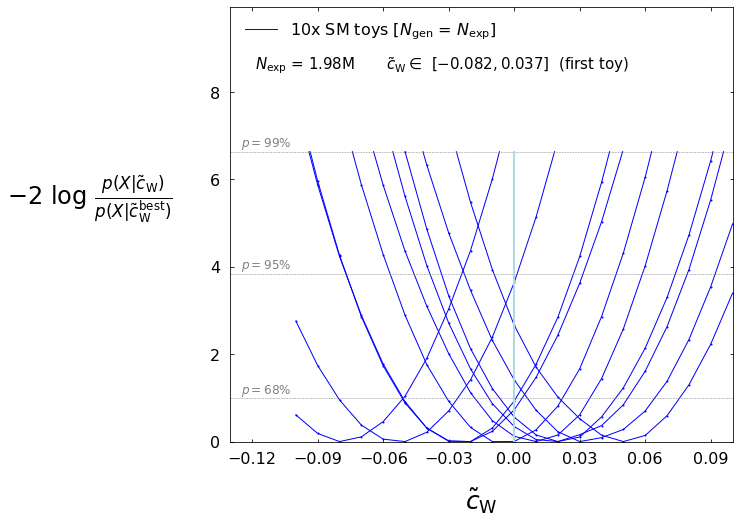

In [96]:
#  Plot Asimov scan and pull out limits
#

fig = plt.figure(figsize=(9, 8))
ax  = fig.add_subplot(1, 1, 1)

profile_y_toys = [profile_y_toy] + profile_y_extra_toys
num_profiles_y = len(profile_y_toys)
for idx, this_profile in enumerate(profile_y_toys[:10]) :
    label = r"10x SM toys [$N_{\rm gen}$ = $N_{\rm exp}$]" if idx == 0 else None
    plot_trimmed_curve(ax, profile_x_toy, this_profile, c="b", markersize=1, linewidth=1, label=label)

for lvl, val in zip(contour_lvls, contour_vals) :
    ax.axhline(val, linestyle="--", linewidth=0.5, color="gray")
    ax.text(-0.125, val, f"$p = {lvl}\%$", ha="left", va="bottom", fontsize=12, color="gray")
    
ax.set_xlim([-0.13, 0.1])
ax.set_ylim([0, 1.5*contour_vals[-1]])

ax.plot([0, 0], [0, contour_vals[-1]], "-", linewidth=2, color="lightblue")

ax.set_xticks([-0.12, -0.09, -0.06, -0.03, 0, 0.03, 0.06, 0.09])
ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16, pad=10)
ax.legend(loc="upper left", fontsize=16, frameon=False)

ax.set_xlabel(r"${\tilde c}_{\rm W}$", fontsize=25, labelpad=20)
ax.set_ylabel(r"$-2~\log~\frac{p(X|{\tilde c}_{\rm W})}{p(X|{\tilde c}_{\rm W}^{\rm best})}$", fontsize=24, labelpad=120, rotation=0)

ax.text(0.05, 0.89, r"$N_{\rm exp}$ = " + f"{L*sigma_tot/1e6:.2f}M", transform=ax.transAxes, ha="left", va="top", fontsize=15)
ax.text(0.31, 0.89, r"${\tilde c}_{\rm W} \in$", transform=ax.transAxes, ha="left", va="top", fontsize=15)

limits_65pct = get_lims(profile_x_toy, profile_y_toy)
ax.text(0.40, 0.89, f"$[{limits_65pct[0]:.3f}, {limits_65pct[1]:.3f}]$  (first toy)", transform=ax.transAxes, ha="left", va="top", fontsize=15)

plt.savefig("figures/asimov/toy_scan.pdf", bbox_inches="tight")
plt.show()



In [321]:
#  Compute logL at SM for generated datapoints
#

start       = time.time()
logL_NULL   = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL      = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")


SM logL computed in 130.53s
cWtil = 0.15 logL computed in 124.41s


In [324]:

test_sig = np.full (fill_value=0.1, shape=(len(fake_white_datapoints),))
start    = time.time()
logL_alt = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
L_alt    = np.exp(logL_alt)
print(f"cWtil = {importance_sampling_cWtil} logL computed in {time.time()-start:.2f}s")


cWtil = 0.15 logL computed in 138.56s


20.29475645114141
[-6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]
20.294756451141186
[-6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]
20.294756451141353
[-6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]
20.294756451141414
[-6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]


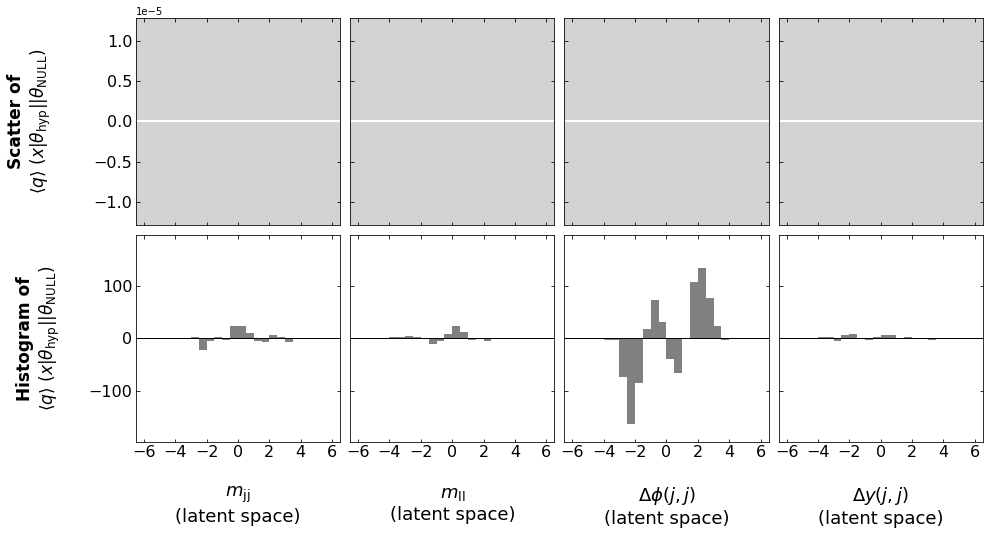

In [329]:
#  Study 1D projections of importance
#

bins=np.linspace(-6.5, 6.5, 27)
    
z_imp     = -2 * L_NULL * (logL_alt - logL_NULL)
z_imp_max = np.max(np.fabs(z_imp))
z_DLL     = -2 * (logL_alt - logL_NULL)
hist_max  = 0
for row_idx in range(num_observables) :
    hist_vals, _ = np.histogram(fake_white_datapoints[:,row_idx], weights=fake_datapoint_weights*z_DLL, bins=bins)
    hist_max     = np.max([hist_max, np.max(np.fabs(hist_vals))])
    print(np.sum(hist_vals))
    print("[" + ", ".join([f"{x:.1f}" for x in _]) + "]")
    
fig = plt.figure(figsize=(3*num_observables, 6))
for row_idx in range(num_observables) :
    x  = fake_white_datapoints[:,row_idx]
    
    ax = fig.add_subplot(2, num_observables, row_idx + 1)
    #ax.scatter(x, z_imp, s=0.5, c=z_imp, cmap="bwr", vmin=-z_imp_max, vmax=z_imp_max)
    ax.set_facecolor("lightgrey")
    ax.axhline(0, c="white", linewidth=2)
    if row_idx == 0 :
        ax.set_ylabel("Scatter of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=41, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*z_imp_max, 1.2*z_imp_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    ax.get_xaxis().set_ticklabels([])
    ax.text(0.95, 1.05, "", ha="right", va="bottom")
    
    x = fake_white_datapoints[:,row_idx]
    ax = fig.add_subplot(2, num_observables, num_observables + row_idx + 1)
    ax.hist(x, weights=fake_datapoint_weights*z_DLL, bins=bins, color="grey")
    ax.axhline(0, c="black", linewidth=1)
    if row_idx == 0 : 
        ax.set_ylabel("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=27, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlabel(observables_labels[observables_order[row_idx]] +"\n(latent space)", fontsize=18, labelpad=25)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*hist_max, 1.2*hist_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.05)
plt.show()
    